![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Descriptive title that follows notebook filename

 - Sign up to the VA Datacube (INSERT LINK) to run this notebook interactively from a browser
 - <b>Compatibility</b>: Notebook currently compatible with both the NCI and DEA Sandbox environments    

 - <b>Products used</b>:
    
    products....
 
 - <b>Special requirements:</b> An optional description of any special requirements, e.g. If running on the NCI, ensure that
    module load otps is run prior to launching this notebook
 
 - <b>Prerequisites:</b> An <i>optional</i> list of any notebooks that should be run or content that should be understood
    prior to launching this notebook
 
 - <b>Notebook Use:</b> If you would like to modify and save this notebook, please copy and paste it into your own folder on the data cube, here is how:

 


## Background


An <i>optional</i> overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. For Beginners_Guide or Frequently_Used_Code notebooks, this may include information about why the particular technique or approach is useful or required. If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. Dhu et al. 2017).

## Description

A <i>compulsory</i> description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above. It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

---------------------------------------------------------------------------------------------------------------------------

## Getting started


Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [2]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import xarray as xr

import sys
# from deafrica_tools.datahandling import load_ard
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [3]:
dc = datacube.Datacube(app='Calculating_band_indices')

### Analysis parameters
An optional section to inform the user of any parameters they'll need to configure to run the notebook:
 - param_name_1: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.
 - param_name_2: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.

 

In [ ]:
param_name_1 = 'example_value'
param_name_2 = 'example_value'

## Create a query and load satellite data

To demonstrate how to compute a remote sensing index, we first need to load in a time series of satellite data for an area. We will use data from the Sentinel 2 satellite:

In [6]:
# Create a query object
lon, lat  = -76.32,36.93
buffer = 0.05

query = {
    'time': ('2021-03', '2021-06'),
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'output_crs': 'epsg:6933',
    'resolution':(-10,10),
}

### Load the data

The **Sentinel-2** product is called:

* `s2_l2a`

And contains images from both Sentinel-2 sensors, S2A and S2B

We will now load in a time-series of satellite images from only Sentinel-2


In [14]:
#Make a list of desired bands to query
bands = ['blue', 'green', 'red', 'nir']

#load data
ds = dc.load(product='s2_l2a',
             measurements=bands,
             dask_chunks={},
             **query)

ds

<xarray.Dataset>
Dimensions:      (time: 50, y: 1026, x: 966)
Coordinates:
  * time         (time) datetime64[ns] 2021-03-01T16:02:51 ... 2021-06-29T16:...
  * y            (y) float64 4.404e+06 4.404e+06 ... 4.394e+06 4.394e+06
  * x            (x) float64 -7.369e+06 -7.369e+06 ... -7.359e+06 -7.359e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1026, 966), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1026, 966), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1026, 966), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1026, 966), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

### Plot the first image to see what it looks like

We can use the `rgb` function to plot the first timestep in our dataset as a true colour RGB image

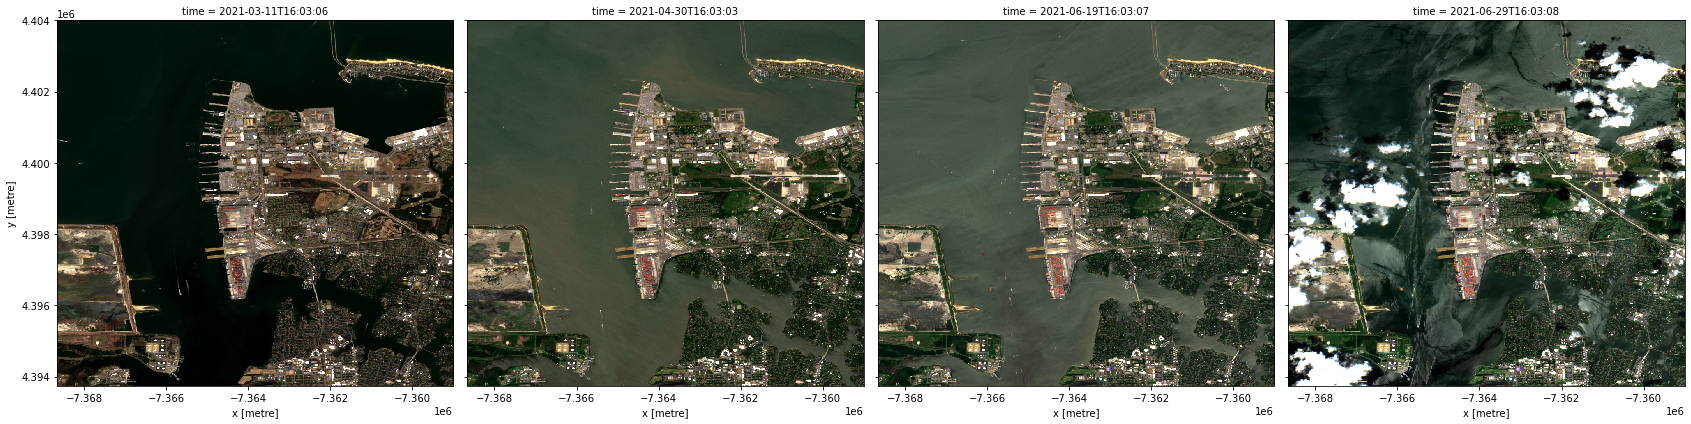

In [15]:
# Plot as an RGB image
rgb(ds, index=[-45, -25, -5, -1])

## Calculate an index for this area manually

One of the most commonly used remote sensing indices is the Normalised Difference Vegetation Index or `NDVI`. This index uses the ratio of the red and near-infrared (NIR) bands to identify live green vegetation. The formula for NDVI is:

$$\text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}$$

Where $\text{NIR}$ is the near-infrared band and $\text{RED}$ is the red band.

When interpreting this index, high values indicate vegetation, and low values indicate soil or water.


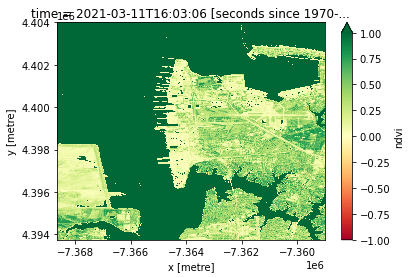

In [24]:
# Calculate NDVI using the formula above
ds['ndvi'] = (ds.nir - ds.red) / (ds.nir + ds.red)

# Plot the results for one time step to see what they look like:
ds.ndvi.isel(time=-45).plot(vmin=-1, vmax=1, cmap='RdYlGn')


## Calculate an index for the same area using calculate_indices function

The `calculate_indices` function provides an easier way to calculate a wide range of remote sensing indices, including:

- <b>AWEI_ns</b> (Automated Water Extraction Index,no shadows, Feyisa 2014)

- <b>AWEI_sh</b> (Automated Water Extraction Index,shadows, Feyisa 2014)

- <b>BAEI</b> (Built-Up Area Extraction Index, Bouzekri et al. 2015)

- <b>BAI</b> (Burn Area Index, Martin 1998)

- <b>BSI</b> (Bare Soil Index, Rikimaru et al. 2002)

- <b>BUI</b> (Built-Up Index, He et al. 2010)

- <b>CMR</b> (Clay Minerals Ratio, Drury 1987)

- <b>EVI</b> (Enhanced Vegetation Index, Huete 2002)

- <b>FMR</b> (Ferrous Minerals Ratio, Segal 1982)

- <b>IOR</b> (Iron Oxide Ratio, Segal 1982)

- <b>LAI</b> (Leaf Area Index, Boegh 2002)

- <b>MNDWI</b> (Modified Normalised Difference Water Index, Xu 1996)

- <b>MSAVI</b> (Modified Soil Adjusted Vegetation Index, Qi et al. 1994)

- <b>NBI</b> (New Built-Up Index, Jieli et al. 2010)

- <b>NBR</b> (Normalised Burn Ratio, Lopez Garcia 1991)

- <b>NDBI</b> (Normalised Difference Built-Up Index, Zha 2003)

- <b>NDCI</b> (Normalised Difference Chlorophyll Index, Mishra & Mishra, 2012)

- <b>NDMI</b> (Normalised Difference Moisture Index, Gao 1996)

- <b>NDSI</b> (Normalised Difference Snow Index, Hall 1995)

- <b>NDVI</b> (Normalised Difference Vegetation Index, Rouse 1973)

- <b>NDWI</b> (Normalised Difference Water Index, McFeeters 1996)

- <b>SAVI</b> (Soil Adjusted Vegetation Index, Huete 1988)

- <b>TCB</b> (Tasseled Cap Brightness, Crist 1985)

- <b>TCG</b> (Tasseled Cap Greeness, Crist 1985)

- <b>TCW</b> (Tasseled Cap Wetness, Crist 1985)

- <b>WI</b> (Water Index, Fisher 2016)





### Using `calculate_indices`, we get the same result:

/tmp/ipykernel_758695/3247325622.py:2: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  ds_ndvi = calculate_indices(ds, index='NDVI', collection='s2')


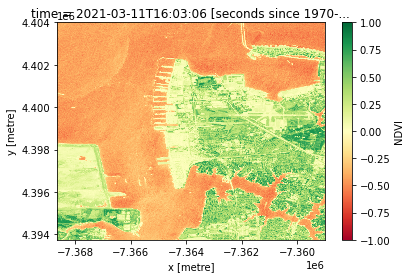

In [23]:
# Calculate NDVI using `calculate indices`
ds_ndvi = calculate_indices(ds, index='NDVI', collection='s2')

# Plot the results 
ds_ndvi.NDVI.isel(time=-45).plot(vmin=-1, vmax=1, cmap='RdYlGn')

***

## Additional information

Notebook copied from https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Calculating_band_indices.html

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 


**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2023

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 